# Ramped Mølmer-Sørensen

In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

In [2]:
# set some plot configs for the notebook
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

Consider two ions (modeled as two-level systems) and a single vibrational mode, addressed by bichromatic light in a rotating frame:

$$
{\hat{H} = \frac{\Omega(t)}{2} \sum\limits_{i=1,2}\bigg[ \bigg(\hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)}\bigg) \otimes e^{i[\eta (\hat{a}e^{-i\nu t} + \hat{a}^{\dagger}e^{i\nu t}) - (\Delta_i t + \phi_i)]} \bigg] + h.c. }
$$ (MS-Hamiltonian)

```{dropdown} Variable definitions:
* $\pmb{\Omega}$: Characterizes the strength of the ion-light interaction, which we assume to be identical for both lasers.
* $\pmb{\hat{\sigma_+}^{(i)}}$: If we model the electronic energy levels of the ion in order of increasing energy as $|1⟩$, $|2⟩$, then $σ̂₊ = |2⟩⟨1|$ (the superscript denotes the ion).
* $\pmb{\eta}$: Denotes the *Lamb-Dicke* factor, which characterizes the strength with which the laser interaction couples the ion's motion to its electronic states.
* $\pmb{â}$: The Boson annihilation operator for the vibrational mode.
* $\pmb{\nu}$: The vibrational mode frequency.
* $\pmb{\Delta_i}$: The detuning of the $i^{th}$ laser from the electronic energy splitting of the ion (assumed to be the same for both ions).
* $\pmb{\phi_i}$: The phase of the $i^{th}$ laser.
```

Assuming $\Delta_{1,2} = \pm (\nu + \epsilon)$, then, under the right conditions, this interaction can be used to produce a maximally entangled Bell state of the two ions. 

```{note}
This interaction is the basis of the Mølmer-Sørensen gate, used by trapped-ion quantum computers.
```

However, in {cite}`Roos_2008` it is shown that a poor choice of the relative phase $\Delta\phi = \phi_1 - \phi_2$ between the two lasers can impact the quality of this process by amplifying the effect of off-resonant carrier transitions. 

```{note}
This effect disappears when $\Delta\phi=0$ and is maximum when $\Delta\phi=\pi$.
```

Fortunately, by ramping up the amplitudes of the lasers, we can eliminate this dependency on $\Delta\phi$.  In practice any smooth ramp that lasts a duration long relative to the period of the ion's motion is sufficient.

In this notebook, we examine this effect, which will demonstrate how to construct time-dependent laser intensity in IonSim.

## Correlated Phase

### Construct the system

In [3]:
# Construct the system
C = Ca40(["S-1/2", "D-1/2"])
L1 = Laser(pointing=[(1, 1.), (2, 1.)])
L2 = Laser(pointing=[(1, 1.), (2, 1.)])
chain = LinearChain(
        ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=2.5e5), vibrational_modes=(;z=[1])
    )
T = Trap(configuration=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/kunal/.julia/packages/IonSim/ZXx4e/src/ion_configurations.jl:160


### Set the laser parameters

In [4]:
mode = T.configuration.vibrational_modes.z[1]

ϵ = 10e3
d = 350  # corrects for AC stark shift from single-photon coupling to sidebands
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L1.Δ = Δf + mode.ν + ϵ - d
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - mode.ν - ϵ + d
L2.k = ẑ
L2.ϵ = x̂

η = abs(get_η(mode, L1, C))
pi_time = η / ϵ  # setting 'resonance' condition: ηΩ = 1/2ϵ
Efield_from_pi_time!(pi_time, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_pi_time!(pi_time, T, 2, 1, ("S-1/2", "D-1/2"));

### Build the Hamiltonian / solve the system

In [5]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);
tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, C["S-1/2"] ⊗ C["S-1/2"] ⊗ mode[0], h);

In [6]:
# setup the Hamiltonian
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);

In [7]:
# solve system
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, C["S-1/2"] ⊗ C["S-1/2"] ⊗ mode[0], h);

  0.254691 seconds (2.94 M allocations: 104.600 MiB, 12.18% gc time)


### Plot results

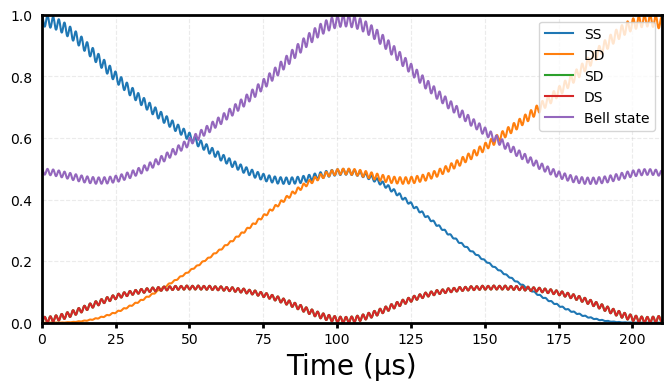

/home/kunal/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kunal/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kunal/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kunal/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kunal/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=

In [8]:
SS = ionprojector(T, "S-1/2", "S-1/2") 
DD = ionprojector(T, "D-1/2", "D-1/2")
SD = ionprojector(T, "S-1/2", "D-1/2")
DS = ionprojector(T, "D-1/2", "S-1/2")
bell_state = dm((C["S-1/2"] ⊗ C["S-1/2"] + 1im * C["D-1/2"] ⊗ C["D-1/2"])/√2) ⊗ one(mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S-1/2⟩|S-1/2⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D-1/2⟩|D-1/2⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S-1/2⟩|D-1/2⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D-1/2⟩|S-1/2⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S-1/2⟩|S-1/2⟩ + i|D-1/2⟩|D-1/2⟩)/√2)

# plot results
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

## Anti-correlated phase

### Update phase

In [9]:
L1.ϕ = -π/2
L2.ϕ = π/2;

### Build the Hamiltonian / solve the system

In [10]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);

In [11]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, C["S-1/2"] ⊗ C["S-1/2"] ⊗ mode[0], h);

  0.243903 seconds (3.24 M allocations: 115.248 MiB, 9.63% gc time)


### Plot results

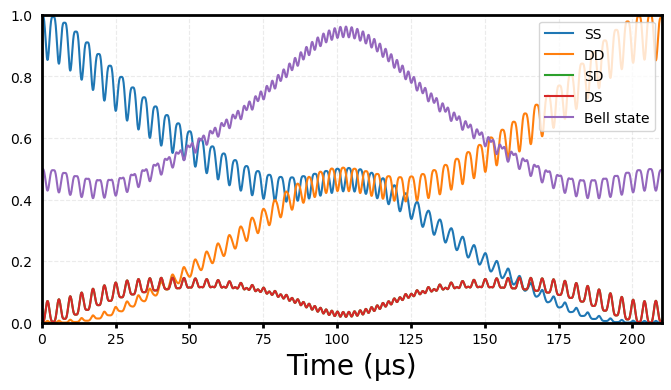

In [12]:
# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S-1/2⟩|S-1/2⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D-1/2⟩|D-1/2⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S-1/2⟩|D-1/2⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D-1/2⟩|S-1/2⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S-1/2⟩|S-1/2⟩ + i|D-1/2⟩|D-1/2⟩)/√2)

# plot results
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

## Anti-correlated phase with ramped laser intensity

### Update intensity profile

In [13]:
E = Efield_from_pi_time(pi_time, T, 1, 1, ("S-1/2", "D-1/2"))
# Simple amplitude ramping function
Ω = t -> t < 20 ? E * sin(2π * t / 80)^2 : E
L1.E = L2.E = t -> Ω(t);

### Build the Hamiltonian / solve the system

In [14]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);

In [15]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:220, C["S-1/2"] ⊗ C["S-1/2"] ⊗ mode[0], h);

  0.393671 seconds (4.92 M allocations: 149.276 MiB, 11.24% gc time, 10.42% compilation time)


### Plot results

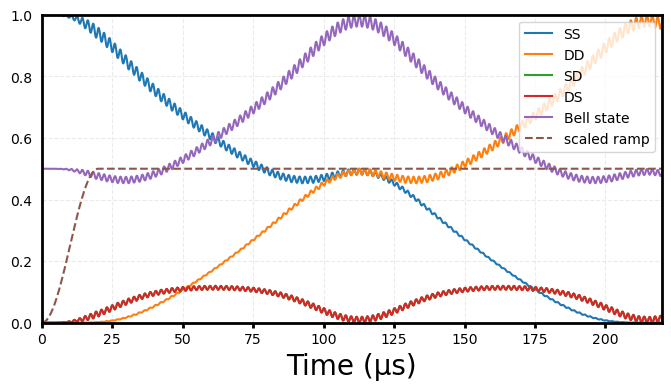

In [16]:
# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S-1/2⟩|S-1/2⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D-1/2⟩|D-1/2⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S-1/2⟩|D-1/2⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D-1/2⟩|S-1/2⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S-1/2⟩|S-1/2⟩ + i|D-1/2⟩|D-1/2⟩)/√2)

# plot results
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.plot(
        tout, @.(Ω(tout) / 2E), 
        linestyle="--", label="scaled ramp"
    )
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");

## Bibliography

```{bibliography} ramped_molmer_sorensen.bib
:filter: docname in docnames
```